Refs:
- data: http://faculty.washington.edu/ivezic/macleod/qso_dr7/Southern.html
- paper: https://arxiv.org/abs/2201.02762

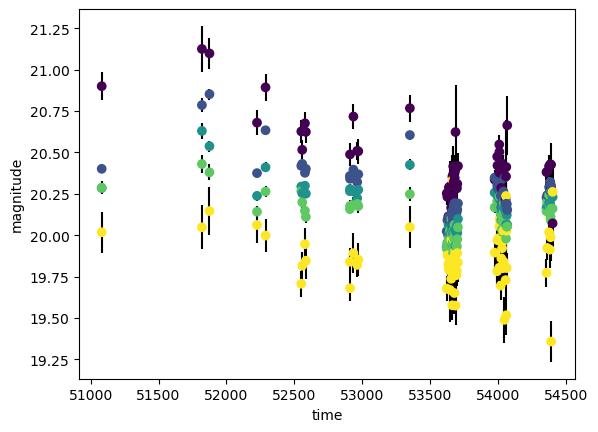

In [1]:
%config InlineBackend.rc = {}

import numpy as np
import matplotlib.pyplot as plt

columns = [
    "MJD_u", "u", "u_err", "MJD_g", "g", "g_err", "MJD_r", "r", "r_err",
    "MJD_i", "i", "i_err", "MJD_z", "z", "z_err",
]
dtype = [(k, float) for k in columns]
data = np.loadtxt("data/2534406", dtype=dtype)

t = []
label = []
y = []
yerr = []
for n, b in enumerate("ugriz"):
    t.append(data[f"MJD_{b}"])
    label.append(np.full(len(data), n, dtype=int))
    y.append(data[b])
    yerr.append(data[f"{b}_err"])
    
t = np.concatenate(t)
label = np.concatenate(label)
y = np.concatenate(y)
yerr = np.concatenate(yerr)

inds = np.argsort(t)
inds = inds[~np.isclose(y[inds], -99.99)]
t = t[inds]
label = label[inds]
y = y[inds]
yerr = yerr[inds]

plt.errorbar(t, y, yerr=yerr, fmt=".k", zorder=-1)
plt.scatter(t, y, c=label)
plt.xlabel("time")
plt.ylabel("magnitude");

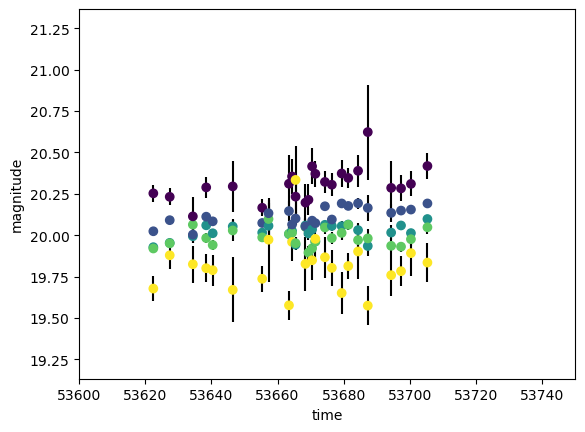

In [2]:
plt.errorbar(t, y, yerr=yerr, fmt=".k", zorder=-1)
plt.scatter(t, y, c=label)
plt.xlabel("time")
plt.ylabel("magnitude")
plt.xlim(53600, 53750);

In [3]:
import jax
import jax.numpy as jnp

import tinygp

jax.config.update("jax_enable_x64", True)

/opt/homebrew/Caskroom/miniforge/base/envs/gp-review/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [4]:
@tinygp.helpers.dataclass
class Multiband(tinygp.kernels.quasisep.Wrapper):
    amplitudes: jnp.ndarray

    def coord_to_sortable(self, X):
        return X[0]

    def observation_model(self, X):
        return self.amplitudes[X[1]] * self.kernel.observation_model(X[0])
    
    
def build_gp(params):
    kernel = tinygp.kernels.quasisep.Exp(
        scale=jnp.exp(params["log_tau"]),
    )
    kernel += tinygp.kernels.quasisep.Matern32(
        sigma=jnp.exp(params["log_sigma"]),
        scale=jnp.exp(params["log_scale"]),
    )
    kernel = Multiband(kernel=kernel, amplitudes=params["amplitudes"])
    mean = lambda X: params["means"][X[1]]
    return tinygp.GaussianProcess(
        kernel,
        (jnp.asarray(t), jnp.array(label)),
        diag=yerr**2 + jnp.exp(2*params["log_jitter"]),
        mean=mean
    )

params = {
    "amplitudes": jnp.array([np.std(y[label == n]) for n in range(5)]),
    "means": jnp.array([np.mean(y[label == n]) for n in range(5)]),
    "log_jitter": jnp.log(1.0),
    "log_tau": jnp.log(50.0),
    "log_sigma": jnp.log(0.1),
    "log_scale": jnp.log(100.0),
}
gp = build_gp(params)

In [5]:
import jaxopt

@jax.jit
def loss(params):
    gp = build_gp(params)
    return -gp.log_probability(y)


print(f"Initial negative log likelihood: {loss(params)}")
solver = jaxopt.ScipyMinimize(fun=loss)
soln = solver.run(params)
print(f"Final negative log likelihood: {soln.state.fun_val}")

Initial negative log likelihood: 322.95833390305665
Final negative log likelihood: -406.6004971502995


In [6]:
soln.params

{'amplitudes': DeviceArray([0.08657529, 0.07934161, 0.06665428, 0.05375704, 0.0307169 ],            dtype=float64),
 'log_jitter': DeviceArray(-3.67208931, dtype=float64),
 'log_scale': DeviceArray(5.2001238, dtype=float64),
 'log_sigma': DeviceArray(0.78656117, dtype=float64),
 'log_tau': DeviceArray(4.65092273, dtype=float64),
 'means': DeviceArray([20.59046605, 20.40939814, 20.29267074, 20.2110952 ,
              19.91339349], dtype=float64)}

In [7]:
gp = build_gp(soln.params)

@jax.jit
def condition(key, X_test):
    cond = gp.condition(y, X_test).gp
    samp = cond.sample(key)
    return cond.loc, jnp.sqrt(cond.variance), samp

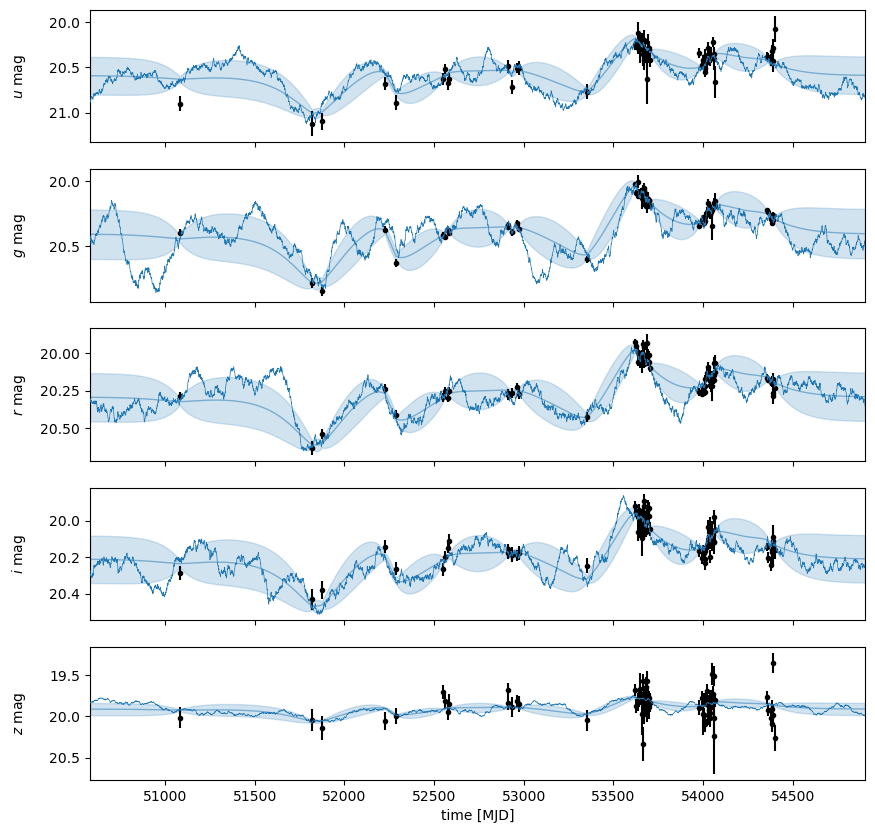

In [8]:
fig, axes = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

t_grid = np.linspace(t.min() - 500, t.max() + 500, 5000)
for n, b in enumerate("ugriz"):
    ax = axes[n]
    mu, std, samp = condition(jax.random.PRNGKey(n), (t_grid, jnp.full(len(t_grid), n)))
    ax.errorbar(t[label==n], y[label==n], yerr=yerr[label==n], fmt="k.")
    ax.plot(t_grid, mu, color="C0", alpha=0.5, lw=1)
    ax.fill_between(t_grid, mu-std, mu+std, color="C0", alpha=0.2)
    ax.plot(t_grid, samp, color="C0", lw=0.5, zorder=100)
    ax.set_ylabel(f"${b}$ mag")
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.yaxis.set_label_coords(-0.08, 0.5)

axes[-1].set_xlabel("time [MJD]")
axes[-1].set_xlim(t_grid.min(), t_grid.max());

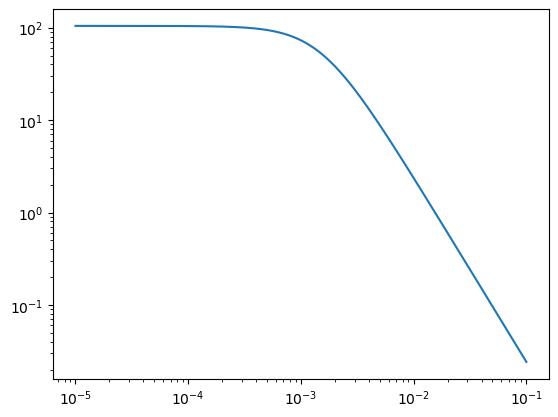

In [9]:
cr = np.exp(-soln.params["log_tau"])
freq = np.exp(np.linspace(np.log(1e-5), np.log(1e-1), 1000))
omega = 2 * np.pi * freq
w2 = omega ** 2

psd = cr / (cr**2 + w2)

plt.loglog(freq, psd)

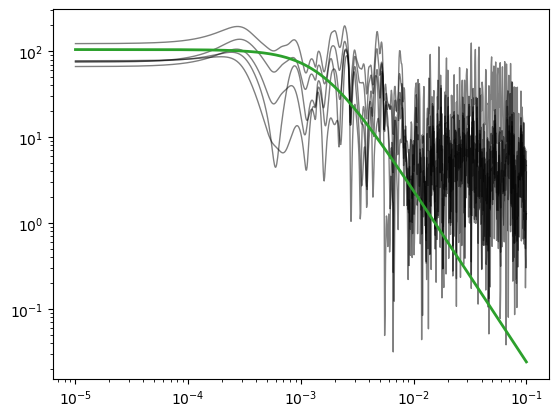

In [16]:
from astropy.timeseries import LombScargle
for n in range(5):
    ls = LombScargle(t[label==n], y[label==n])
    power = ls.power(freq)
    plt.loglog(freq, power / soln.params["amplitudes"][n] ** 2, alpha=0.5, lw=1, color="k")
plt.loglog(freq, psd, color="C2", lw=2)